In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob as gb
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from skimage.io import imread
import random

In [2]:
train_path = '/kaggle/input/fer2013/train'
test_path = '/kaggle/input/fer2013/test'

In [3]:
counts_trainImages = {}
for folder in os.listdir(train_path):
  images = gb.glob(pathname = train_path + '/' + folder + '/*.jpg')
  counts_trainImages[folder] = len(images)

In [4]:
print(pd.DataFrame(counts_trainImages, index=['Train Data']))

            surprise  fear  angry  neutral   sad  disgust  happy
Train Data      3171  4097   3995     4965  4830      436   7215


In [5]:
counts_testImages = {}
for folder in os.listdir(test_path):
  images = gb.glob(pathname = test_path + '/'+ folder + '/*.jpg')
  counts_testImages[folder] = len(images)

In [6]:
print(pd.DataFrame(counts_testImages, index=['Test Data']))

           surprise  fear  angry  neutral   sad  disgust  happy
Test Data       831  1024    958     1233  1247      111   1774


In [7]:
data = []
for folder in os.listdir(train_path):
  class_folder = os.path.join(train_path, folder)
  for file in os.listdir(class_folder):
    image_path = os.path.join(class_folder, file)
    if image_path.endswith('jpg'):
      data.append([image_path, folder])

In [8]:
data_train = pd.DataFrame(data, columns=('filename', 'class'))

In [9]:
data_train.head()

,filename,class
0,/kaggle/input/fer2013/train/surprise/Training_...,surprise
1,/kaggle/input/fer2013/train/surprise/Training_...,surprise
2,/kaggle/input/fer2013/train/surprise/Training_...,surprise
3,/kaggle/input/fer2013/train/surprise/Training_...,surprise
4,/kaggle/input/fer2013/train/surprise/Training_...,surprise


In [10]:
data_train.shape

(28709, 2)

In [11]:
data_train['class'].value_counts()

class
happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
disgust      436
Name: count, dtype: int64

In [12]:
data_train.isnull().sum()

filename    0
class       0
dtype: int64

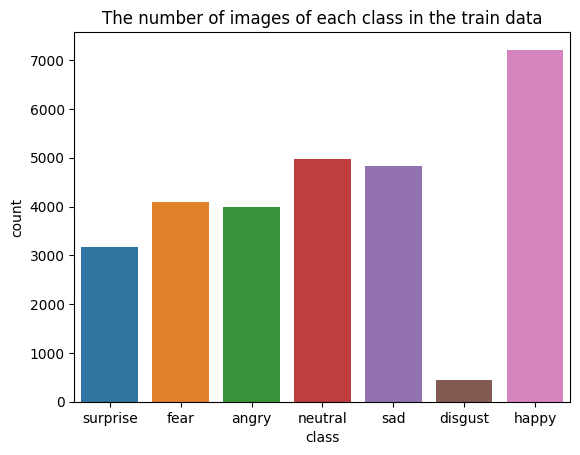

In [13]:
sns.countplot(x = data_train["class"])
plt.title('The number of images of each class in the train data')
plt.show()

In [14]:
data_train = data_train.drop(data_train[data_train['class'] == 'disgust'].index)

In [15]:
data_train.shape

(28273, 2)

In [16]:
data = []
for folder in os.listdir(test_path):
  class_folder = os.path.join(test_path, folder)
  for file in os.listdir(class_folder):
    image_path = os.path.join(class_folder, file)
    if image_path.endswith('jpg'):
      data.append([image_path, folder])

In [17]:
data_test = pd.DataFrame(data, columns=('filename', 'class'))

In [18]:
data_test.head()

,filename,class
0,/kaggle/input/fer2013/test/surprise/PublicTest...,surprise
1,/kaggle/input/fer2013/test/surprise/PrivateTes...,surprise
2,/kaggle/input/fer2013/test/surprise/PrivateTes...,surprise
3,/kaggle/input/fer2013/test/surprise/PublicTest...,surprise
4,/kaggle/input/fer2013/test/surprise/PrivateTes...,surprise


In [19]:
data_test.shape

(7178, 2)

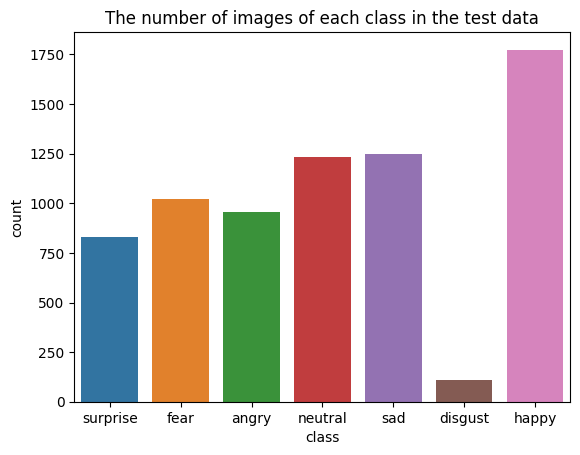

In [20]:
sns.countplot(x = data_test["class"])
plt.title('The number of images of each class in the test data')
plt.show()

In [21]:
data_test = data_test.drop(data_test[data_test['class'] == 'disgust'].index)

In [22]:
data_test.shape

(7067, 2)

In [23]:
ros = RandomOverSampler(random_state=42)
x_resampled, y_resampled = ros.fit_resample(data_train[['filename']], data_train['class'])

balanced_data_train = pd.DataFrame({
    'filename': x_resampled['filename'],
    'class': y_resampled
})

In [24]:
balanced_data_train.shape

(43290, 2)

In [25]:
balanced_data_train['class'].value_counts()

class
surprise    7215
fear        7215
angry       7215
neutral     7215
sad         7215
happy       7215
Name: count, dtype: int64

In [26]:
ros = RandomOverSampler(random_state=42)
x_resampled, y_resampled = ros.fit_resample(data_test[['filename']], data_test['class'])

balanced_data_test = pd.DataFrame({
    'filename': x_resampled['filename'],
    'class': y_resampled
})

In [27]:
balanced_data_test.shape

(10644, 2)

In [28]:
balanced_data_test['class'].value_counts()

class
surprise    1774
fear        1774
angry       1774
neutral     1774
sad         1774
happy       1774
Name: count, dtype: int64

In [29]:
# splitting the training dataframe into train and val
df_train, df_valid = train_test_split(balanced_data_train,  test_size= 0.2, random_state= 42)

In [30]:
df_train.shape

(34632, 2)

In [31]:
df_valid.shape

(8658, 2)

In [32]:
data_generator = ImageDataGenerator(rescale=1./255, rotation_range=0.2, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,
                                    zoom_range=.1, fill_mode='nearest')

In [33]:
train_generator = data_generator.flow_from_dataframe(df_train, x_col= 'filename', y_col= 'class', target_size= (48,48), class_mode= 'categorical',
                                    color_mode= 'grayscale', batch_size=32)

Found 34632 validated image filenames belonging to 6 classes.


In [34]:
valid_test_generator = ImageDataGenerator(rescale=1./255)

In [35]:
valid_generator = valid_test_generator.flow_from_dataframe(df_valid, x_col= 'filename', y_col= 'class', target_size= (48,48), class_mode= 'categorical',
                                     color_mode= 'grayscale', shuffle= False, batch_size=32)

Found 8658 validated image filenames belonging to 6 classes.


In [36]:
test_generator = valid_test_generator.flow_from_dataframe(balanced_data_test, x_col= 'filename', y_col= 'class', target_size= (48,48), class_mode= 'categorical',
                                    color_mode= 'grayscale', shuffle= False, batch_size=32 )

Found 10644 validated image filenames belonging to 6 classes.


In [37]:
model = Sequential([
    
        Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(48,48,1)),
        Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu' ),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),
    
        Conv2D(filters=128, kernel_size=(5,5), padding='same', activation='relu' ),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),
    
        Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),
    
        Conv2D(filters=512, kernel_size=(3,3),padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),
    
        Flatten(),
    
        Dense(256, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.25),
    
        Dense(512, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.25),

# Output Layer
        Dense(6, activation = 'softmax'),
        ])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 23, 23, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 11, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 5, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,841,030 (14.65 MB)

 Trainable params: 3,837,062 (14.64 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [39]:
model.compile(Adam(learning_rate=0.001),loss='categorical_crossentropy', metrics=["accuracy"])

In [40]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [41]:
history = model.fit(train_generator , epochs= 100 , verbose= 1, validation_data= valid_generator, callbacks=[early_stopping])

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728759473.013944      70 service.cc:145] XLA service 0x7bc03c008da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728759473.014029      70 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728759473.014036      70 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   1/1083 ━━━━━━━━━━━━━━━━━━━━ 5:59:29 20s/step - accuracy: 0.0625 - loss: 10.0240

I0000 00:00:1728759487.196591      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1083/1083 ━━━━━━━━━━━━━━━━━━━━ 185s 152ms/step - accuracy: 0.2015 - loss: 5.8531 - val_accuracy: 0.2275 - val_loss: 2.4282
Epoch 2/100
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 56s 52ms/step - accuracy: 0.2921 - loss: 2.3757 - val_accuracy: 0.2193 - val_loss: 3.0359
Epoch 3/100
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 55s 50ms/step - accuracy: 0.3801 - loss: 2.6613 - val_accuracy: 0.4500 - val_loss: 2.3138
Epoch 4/100
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 54s 50ms/step - accuracy: 0.4322 - loss: 2.4871 - val_accuracy: 0.4129 - val_loss: 2.5148
Epoch 5/100
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 54s 49ms/step - accuracy: 0.4519 - loss: 2.3999 - val_accuracy: 0.4444 - val_loss: 2.4165
Epoch 6/100
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 54s 50ms/step - accuracy: 0.4583 - loss: 2.3550 - val_accuracy: 0.4673 - val_loss: 2.2668
Epoch 7/100
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 54s 50ms/step - accuracy: 0.4724 - loss: 2.2652 - val_accuracy: 0.4941 - val_loss: 2.5058
Epoch 8/100
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 55s 50ms/step - accuracy: 0.4812 - l

In [42]:
train_loss, train_accu = model.evaluate(train_generator)
valid_loss, valid_accu = model.evaluate(valid_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, valid_accu*100))

1083/1083 ━━━━━━━━━━━━━━━━━━━━ 46s 43ms/step - accuracy: 0.5702 - loss: 1.4730
271/271 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5854 - loss: 1.4440
final train accuracy = 57.46 , validation accuracy = 58.69


In [43]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

333/333 ━━━━━━━━━━━━━━━━━━━━ 36s 109ms/step - accuracy: 0.5525 - loss: 1.5004
Test Loss: 1.4745477437973022
Test Accuracy: 0.5711199045181274


In [44]:
def plot_training_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

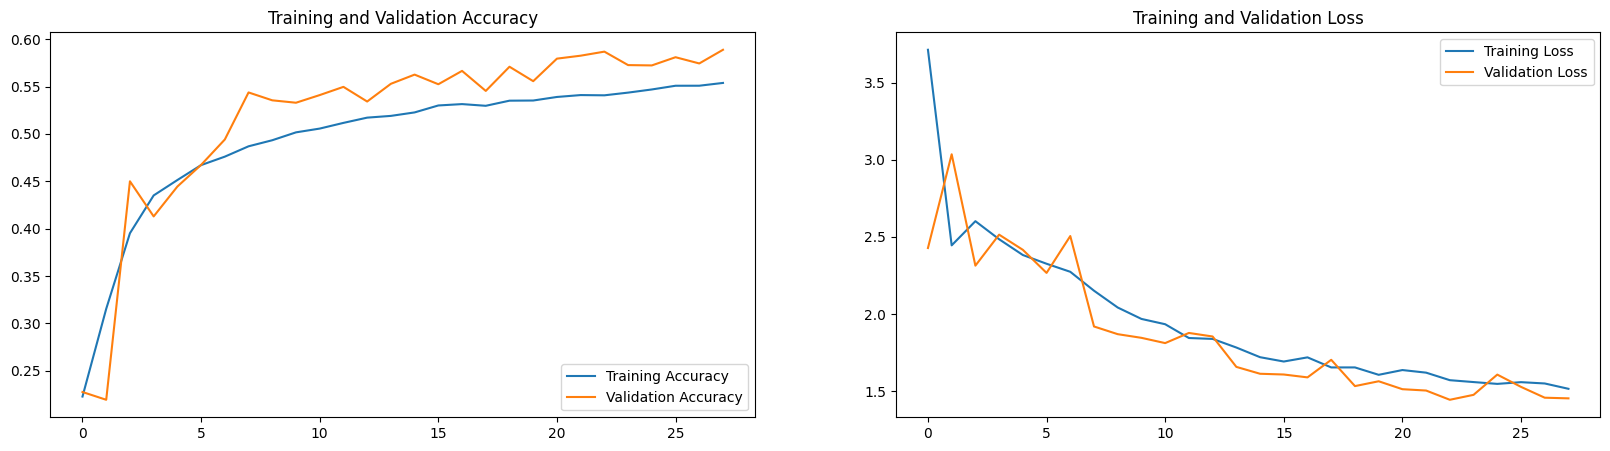

In [45]:
plot_training_history(history)

In [46]:
predictions = model.predict(test_generator, verbose=1)

333/333 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step


In [47]:
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

[5 5 5 ... 5 5 5]


In [48]:
true_classes = test_generator.classes

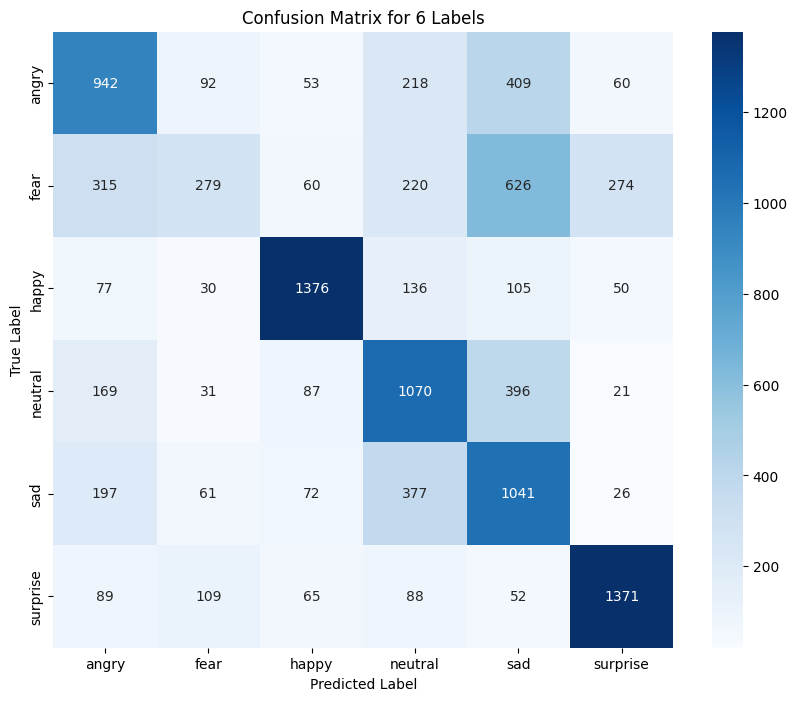

In [49]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)

labels = list(test_generator.class_indices.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for 6 Labels')
plt.show()

In [50]:
class_report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print(class_report)

              precision    recall  f1-score   support

       angry       0.53      0.53      0.53      1774
        fear       0.46      0.16      0.23      1774
       happy       0.80      0.78      0.79      1774
     neutral       0.51      0.60      0.55      1774
         sad       0.40      0.59      0.47      1774
    surprise       0.76      0.77      0.77      1774

    accuracy                           0.57     10644
   macro avg       0.58      0.57      0.56     10644
weighted avg       0.58      0.57      0.56     10644



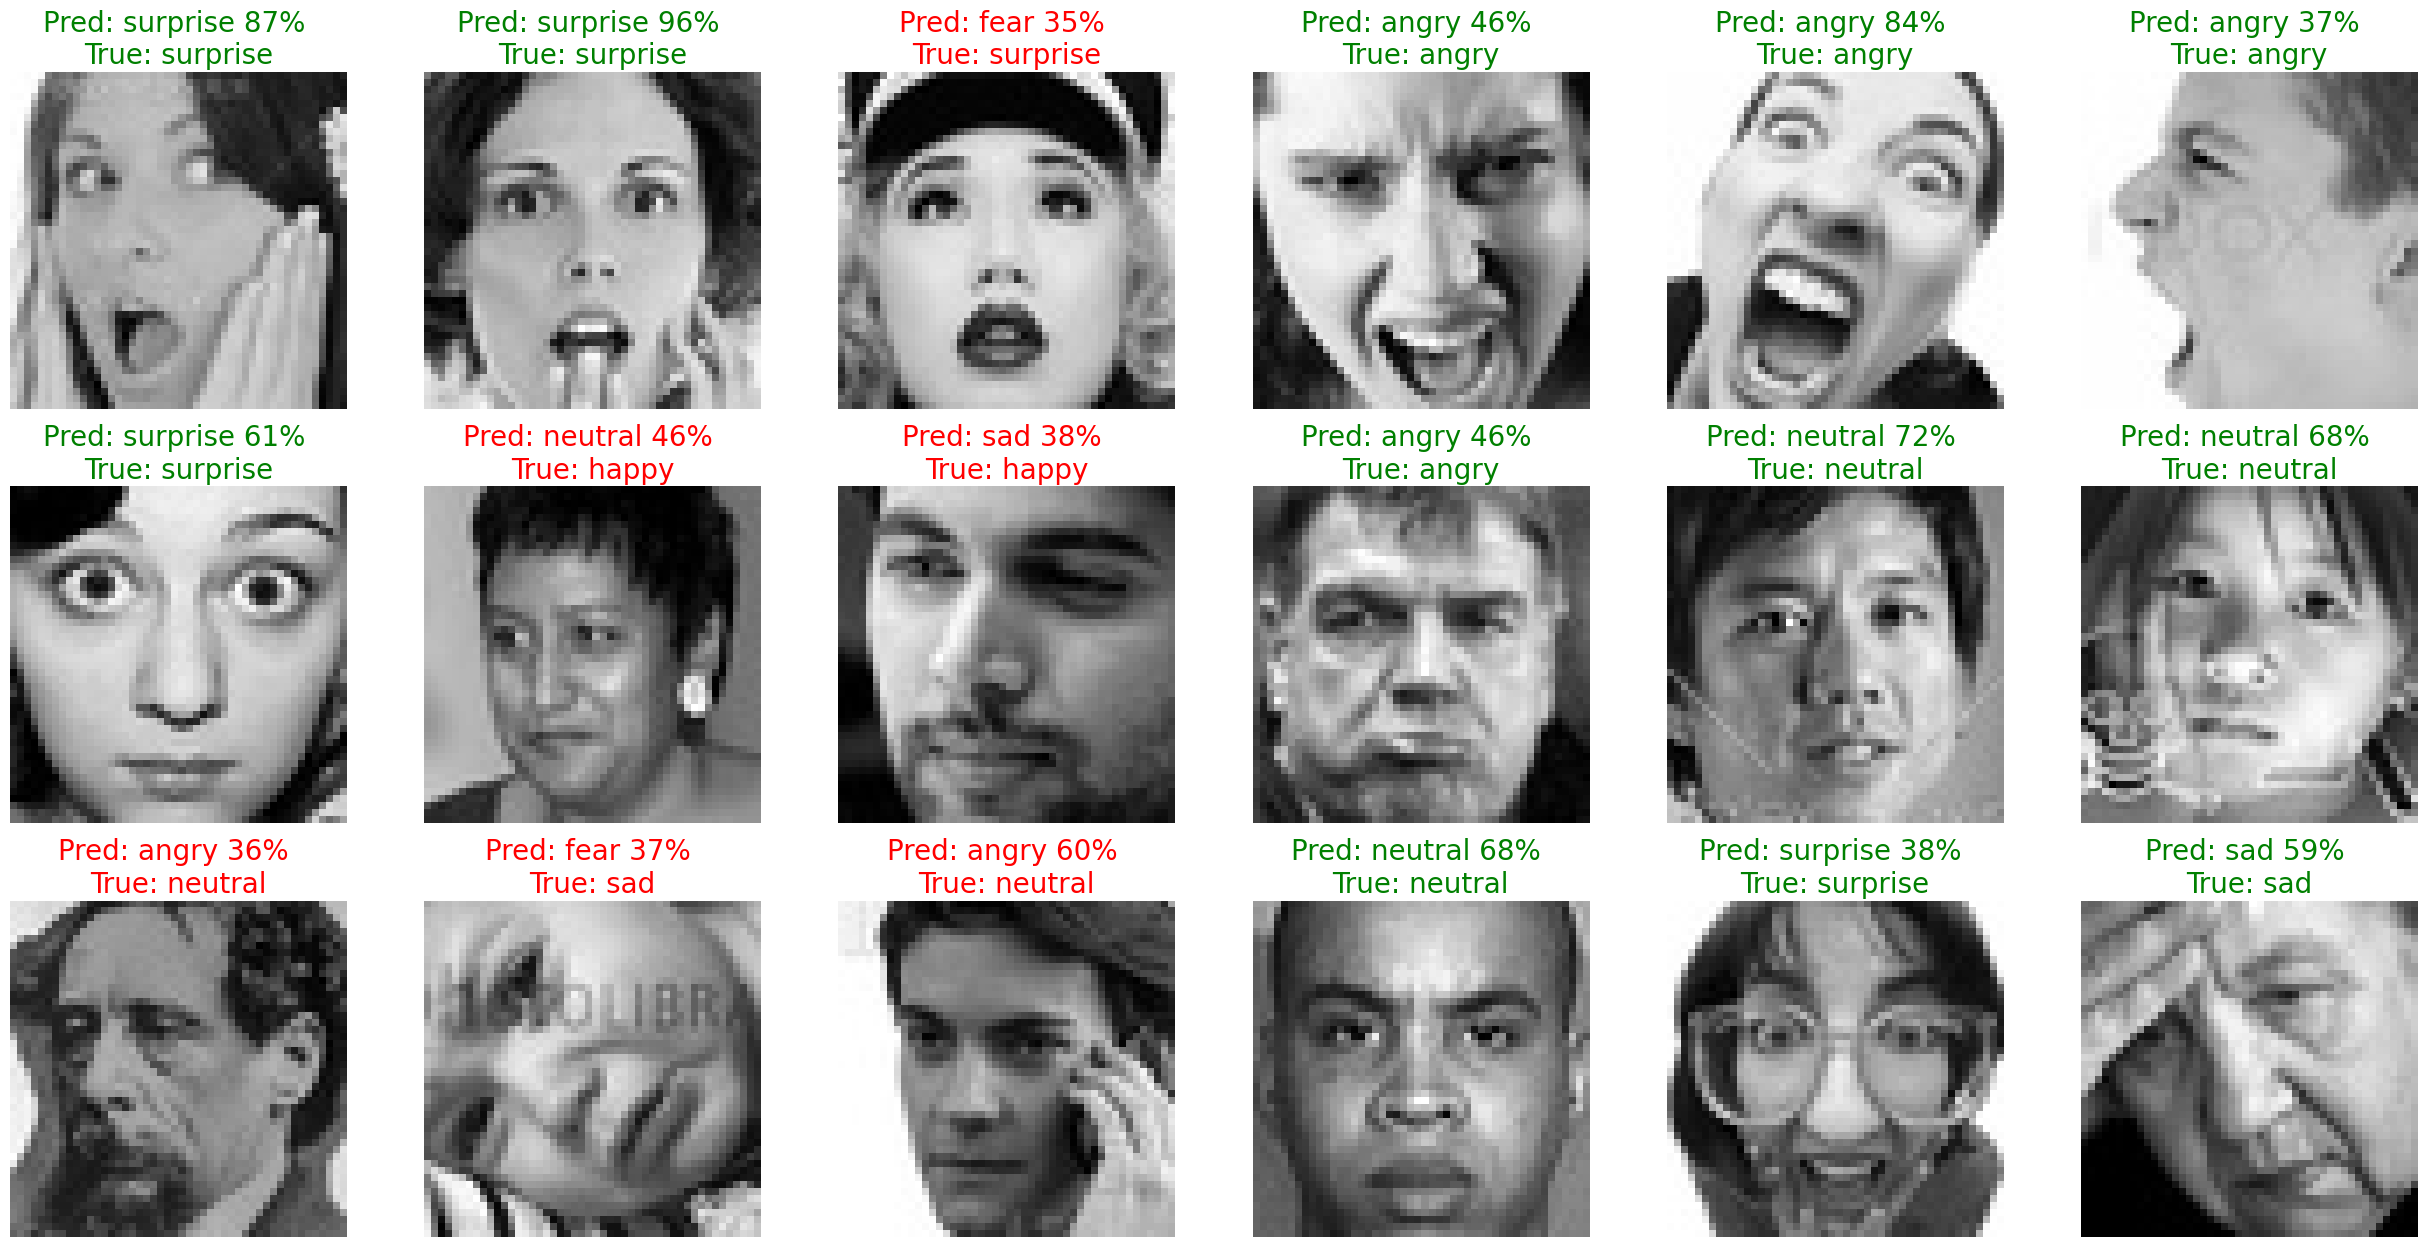

In [51]:
class_labels = list(test_generator.class_indices.keys())

filenames = test_generator.filenames
plt.figure(figsize=(25, 25))
num_images = 18

for i in range(num_images):
    # Load and plot the image
    random_index = random.randint(0, len(test_generator.filenames) - 1)
    image_path = test_generator.filepaths[random_index]
    img = imread(image_path)
    plt.subplot(6, 6, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    is_correct = predicted_classes[random_index] == true_classes[random_index]
    color = 'green' if is_correct else 'red'

    predicted_label = class_labels[predicted_classes[random_index]]
    true_label = class_labels[true_classes[random_index]]
    
    plt.title("{} {:2.0f}% {}".format('Pred: '+predicted_label,100*np.max(predictions[random_index]),'\nTrue: '+true_label),color=color, fontsize=20)

plt.tight_layout()
plt.show()

In [52]:
import pickle as pkl

In [53]:
pkl.dump(model,open('model02.pkl','wb'))